<a href="https://colab.research.google.com/github/swaroop-raj/machine-learning/blob/main/machine-learning/machine-learning/Walmart_Recruiting_Trip_Type_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Description
Walmart uses both art and science to continually make progress on their core mission of better understanding and serving their customers. One way Walmart is able to improve customers' shopping experiences is by segmenting their store visits into different trip types. 



Whether they're on a last minute run for new puppy supplies or leisurely making their way through a weekly grocery list, classifying trip types enables Walmart to create the best shopping experience for every customer.

Currently, Walmart's trip types are created from a combination of existing customer insights ("art") and purchase history data ("science"). In their third recruiting competition, Walmart is challenging Kagglers to focus on the (data) science and classify customer trips using only a transactional dataset of the items they've purchased. Improving the science behind trip type classification will help Walmart refine their segmentation process.

Walmart is hosting this competition to connect with data scientists who break the mold.

## Evaluation 

Submissions are evaluated using the multi-class logarithmic loss. For each visit, you must submit a set of predicted probabilities oneforeveryTripType. The formula is:

−1N∑i=1N∑j=1Myijlog(pij),

where N is the number of visits in the test set, M is the number of trip types, \\(log\\) is the natural logarithm, \\(y_{ij}\\) is 1 if observation \\(i\\) is of class \\(j\\) and 0 otherwise, and \\(p_{ij}\\) is the predicted probability that observation \\(i\\) belongs to class \\(j\\).

The submitted probabilities for a given visit are not required to sum to one because they are rescaled prior to being scored eachrowisdividedbytherowsum. In order to avoid the extremes of the log function, predicted probabilities are replaced with \\(max(min(p,1-10^{-15}),10^{-15})\\).

## Data Description

For this competition, you are tasked with categorizing shopping trip types based on the items that customers purchased. To give a few hypothetical examples of trip types: a customer may make a small daily dinner trip, a weekly large grocery trip, a trip to buy gifts for an upcoming holiday, or a seasonal trip to buy clothes.

Walmart has categorized the trips contained in this data into 38 distinct types using a proprietary method applied to an extended set of data. You are challenged to recreate this categorization/clustering with a more limited set of features. This could provide new and more robust ways to categorize trips.

The training set (train.csv) contains a large number of customer visits with the TripType included. You must predict the TripType for each customer visit in the test set (test.csv). Each visit may only have one TripType. You will not be provided with more information than what is given in the data (e.g. what the TripTypes represent or more product information).

### Data fields

TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.

VisitNumber - an id corresponding to a single trip by a single customer

Weekday - the weekday of the trip

Upc - the UPC number of the product purchased

ScanCount - the number of the given item that was 
purchased. A negative value indicates a product return.

DepartmentDescription - a high-level description of the item's department

FinelineNumber - a more refined category for each of the products, created by Walmart


**Importing the packages** 




In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score , f1_score , roc_auc_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from yellowbrick.classifier import ClassificationReport, ROCAUC

plt.style.use('ggplot')
pd.options.display.float_format = '{:,.2f}'.format
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


np.set_printoptions(suppress=True)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


**Reading the train and test dataset** 

In [2]:
cdata = pd.read_csv('/content/wallmart-train.csv')
x_test = pd.read_csv('/content/wallmart-test.csv')

In [3]:
cdata.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,"68,113,152,929.00",-1,FINANCIAL SERVICES,"1,000.00"
1,30,7,Friday,"60,538,815,980.00",1,SHOES,"8,931.00"
2,30,7,Friday,"7,410,811,099.00",1,PERSONAL CARE,"4,504.00"
3,26,8,Friday,"2,238,403,510.00",2,PAINT AND ACCESSORIES,"3,565.00"
4,26,8,Friday,"2,006,613,744.00",2,PAINT AND ACCESSORIES,"1,017.00"


In [4]:
x_test.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,1,Friday,"72,503,389,714.00",1,SHOES,"3,002.00"
1,1,Friday,"1,707,710,732.00",1,DAIRY,"1,526.00"
2,1,Friday,"89,470,001,026.00",1,DAIRY,"1,431.00"
3,1,Friday,"88,491,211,470.00",1,GROCERY DRY GOODS,"3,555.00"
4,2,Friday,"2,840,015,224.00",1,DSD GROCERY,"4,408.00"


In [5]:
x_test.isnull().sum()

VisitNumber                 0
Weekday                     0
Upc                      3986
ScanCount                   0
DepartmentDescription    1328
FinelineNumber           3986
dtype: int64

In [6]:
cdata.shape

(647054, 7)

In [7]:
cdata.nunique()

TripType                    38
VisitNumber              95674
Weekday                      7
Upc                      97714
ScanCount                   39
DepartmentDescription       68
FinelineNumber            5195
dtype: int64

In [8]:
cdata.isnull().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

In [9]:
print(cdata['DepartmentDescription'].value_counts(normalize=True))
plt.show()

GROCERY DRY GOODS        0.11
DSD GROCERY              0.11
PRODUCE                  0.08
DAIRY                    0.07
PERSONAL CARE            0.06
                         ... 
LARGE HOUSEHOLD GOODS    0.00
CONCEPT STORES           0.00
SEASONAL                 0.00
OTHER DEPARTMENTS        0.00
HEALTH AND BEAUTY AIDS   0.00
Name: DepartmentDescription, Length: 68, dtype: float64


In [10]:
cdata[cdata['DepartmentDescription'].notnull() & cdata['FinelineNumber'].isnull()]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
1155,44,496,Friday,nan,1,PHARMACY RX,nan
1216,5,521,Friday,nan,1,PHARMACY RX,nan
1373,5,585,Friday,nan,1,PHARMACY RX,nan
1455,5,619,Friday,nan,1,PHARMACY RX,nan
1456,5,619,Friday,nan,1,PHARMACY RX,nan
...,...,...,...,...,...,...,...
636715,5,188839,Sunday,nan,1,PHARMACY RX,nan
636716,5,188839,Sunday,nan,1,PHARMACY RX,nan
636717,5,188839,Sunday,nan,1,PHARMACY RX,nan
636847,5,188896,Sunday,nan,1,PHARMACY RX,nan


In [11]:
cdata.describe()

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,"647,054.00","647,054.00","642,925.00","647,054.00","642,925.00"
mean,58.58,"96,167.64","30,606,982,273.49",1.11,"3,726.88"
std,157.64,"55,545.49","91,201,337,280.41",0.70,"2,780.97"
min,3.00,5.00,834.00,-12.00,0.00
25%,27.00,"49,268.00","3,400,000,995.00",1.00,"1,404.00"
50%,39.00,"97,074.00","7,050,102,580.00",1.00,"3,352.00"
75%,40.00,"144,316.00","30,065,314,449.00",1.00,"5,501.00"
max,999.00,"191,347.00","978,970,666,419.00",71.00,"9,998.00"


In [12]:
cdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TripType               647054 non-null  int64  
 1   VisitNumber            647054 non-null  int64  
 2   Weekday                647054 non-null  object 
 3   Upc                    642925 non-null  float64
 4   ScanCount              647054 non-null  int64  
 5   DepartmentDescription  645693 non-null  object 
 6   FinelineNumber         642925 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


In [13]:
cdata_fl_null_index = cdata.index[cdata['DepartmentDescription'].notnull() & cdata['FinelineNumber'].isnull()].tolist()
cdata.loc[cdata_fl_null_index, 'FinelineNumber'] = 0


In [14]:
cdata_upc_null_index = cdata.index[cdata['DepartmentDescription'].notnull() & cdata['Upc'].isnull()].tolist()
cdata.loc[cdata_upc_null_index, 'Upc'] = 0


In [15]:
cdata.isnull().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      1361
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           1361
dtype: int64

In [16]:
cdata[cdata['DepartmentDescription'].isnull() & cdata['FinelineNumber'].isnull() & cdata['Upc'].isnull()]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
25,26,8,Friday,nan,1,NaN,nan
548,27,259,Friday,nan,3,NaN,nan
549,27,259,Friday,nan,1,NaN,nan
959,999,409,Friday,nan,-1,NaN,nan
1116,39,479,Friday,nan,1,NaN,nan
...,...,...,...,...,...,...,...
643137,41,190408,Sunday,nan,1,NaN,nan
643991,44,190651,Sunday,nan,1,NaN,nan
645990,44,191080,Sunday,nan,-1,NaN,nan
645991,44,191080,Sunday,nan,1,NaN,nan


In [17]:
cdata.dropna(inplace=True)
cdata.isnull().sum()

TripType                 0
VisitNumber              0
Weekday                  0
Upc                      0
ScanCount                0
DepartmentDescription    0
FinelineNumber           0
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


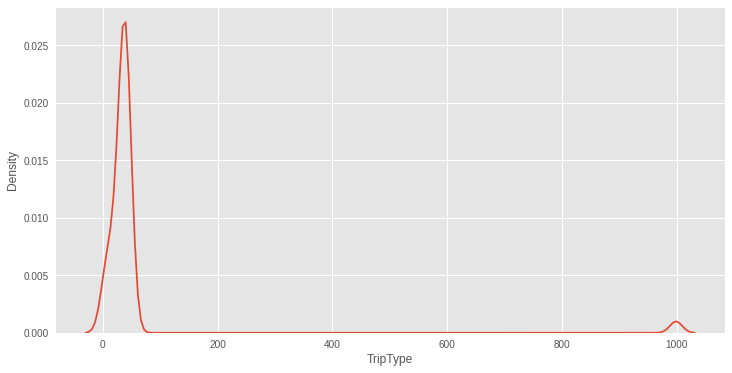

In [18]:
plt.figure(figsize=(12,6))
sns.distplot(cdata.TripType,hist=False)

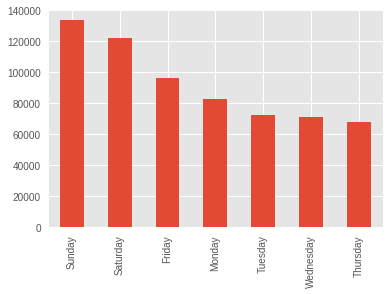

In [19]:
cdata['Weekday'].value_counts().plot(kind='bar')
plt.show()

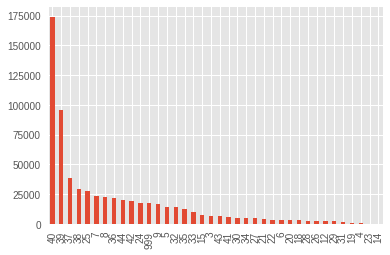

In [20]:
cdata['TripType'].value_counts().plot(kind='bar')
plt.show()

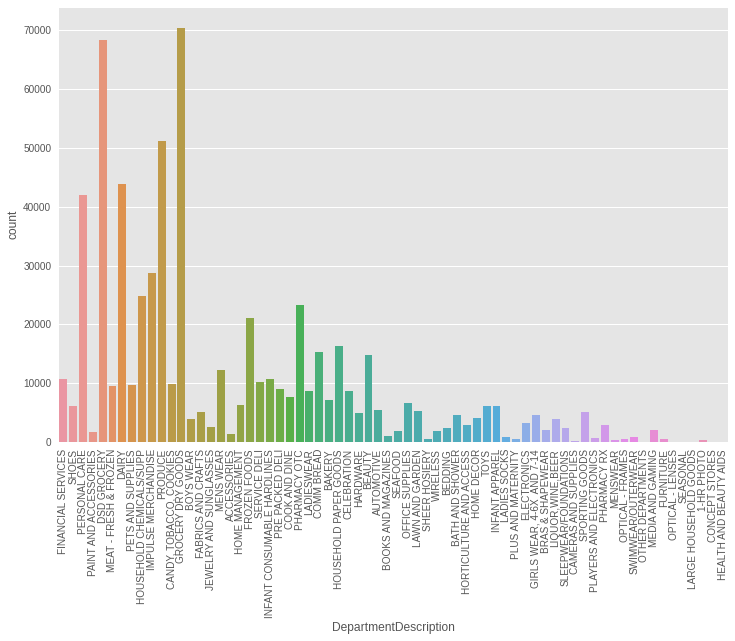

In [21]:
plt.figure(figsize=(12,8))
sns.countplot(data=cdata, x='DepartmentDescription' , orient="v")
plt.xticks(rotation=90)
plt.show()

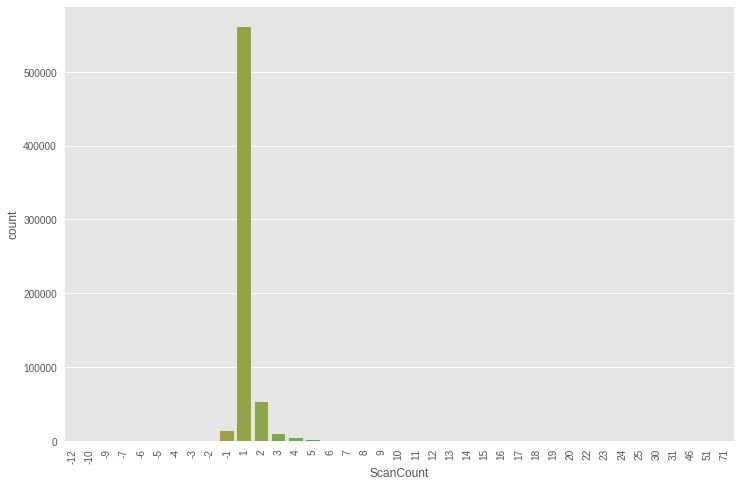

In [22]:
plt.figure(figsize=(12,8))
sns.countplot(data=cdata, x='ScanCount' , orient="v")
plt.xticks(rotation=90)
plt.show()

In [23]:
cdata['ScanCount'].value_counts()

 1     560409
 2      52928
-1      14233
 3       9428
 4       4531
 5       1379
 6        865
-2        802
 8        246
 7        228
-3        137
 10       130
 9         88
-4         73
 12        60
 11        45
-5         16
 14        15
 13        13
 15        12
-6          9
 20         7
 16         6
 18         4
 24         4
 19         4
 25         3
 17         3
 23         3
 22         2
-9          2
 30         1
 46         1
 51         1
 71         1
-12         1
-10         1
-7          1
 31         1
Name: ScanCount, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


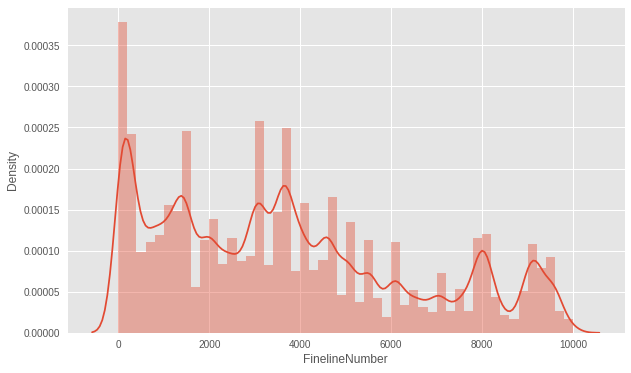

In [24]:
plt.figure(figsize=(10,6))
sns.distplot(cdata.FinelineNumber,hist=True)
plt.show()

In [25]:
cdata['TripType'] = cdata['TripType'].astype('category')
cdata['Weekday'] = cdata['Weekday'].astype('category')
cdata.dtypes

TripType                 category
VisitNumber                 int64
Weekday                  category
Upc                       float64
ScanCount                   int64
DepartmentDescription      object
FinelineNumber            float64
dtype: object

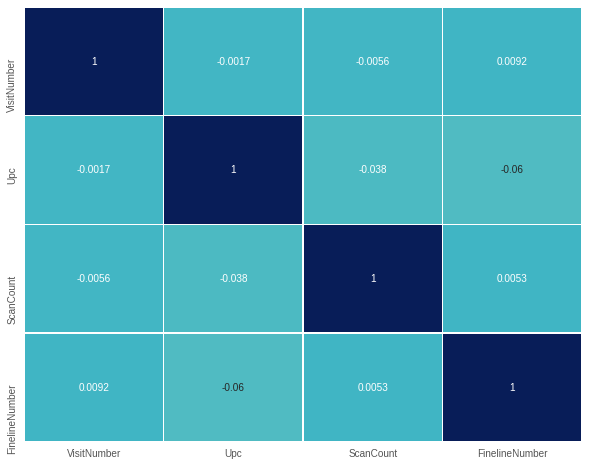

In [26]:
plt.figure(figsize=(10,8))

sns.heatmap(cdata.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")

plt.show()

In [27]:
pd.crosstab(cdata['TripType'],cdata['DepartmentDescription'],normalize='columns')

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HEALTH AND BEAUTY AIDS,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,JEWELRY AND SUNGLASSES,LADIES SOCKS,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENS WEAR,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PHARMACY RX,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
TripType,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.99,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.01,0.01,0.01,0.01,0.02,0.00,0.02,0.00,0.00,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.00,0.00,0.01,0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.02,0.00,0.00,0.01,0.02,0.00,0.00,0.01,0.01,0.00,0.01,0.01,0.00,0.01,0.68,1.00,0.00,0.01,0.02,0.01,0.23,0.93,0.00,0.00,0.00,0.01,0.00,0.03,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.01
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.01,0.01,0.01,0.13,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.02,0.01,0.09,0.00,0.01,0.03,0.03,0.00,0.01,0.01,0.11,0.00,0.00,0.05,0.01,0.00,0.01,0.00,0.00,0.01,0.01,0.02,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.02,0.16,0.00,0.00,0.00,0.01,0.01,0.00,0.03,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.09,0.06,0.17,0.00,0.36,0.01,0.00,0.01,0.01,0.00,0.00,0.01
8,0.00,0.00,0.01,0.07,0.01,0.07,0.00,0.02,0.00,0.00,0.00,0.06,0.01,0.03,0.00,0.01,0.04,0.07,0.00,0.01,0.00,0.02,0.00,0.00,0.02,0.01,0.00,0.01,0.01,0.00,0.04,0.04,0.09,0.00,0.03,0.01,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.06,0.06,0.03,0.00,0.00,0.00,0.01,0.04,0.00,0.00,0.02,0.01,0.01,0.00,0.01,0.01,0.00,0.00
9,0.20,0.14,0.16,0.01,0.05,0.01,0.06,0.10,0.07,0.08,0.31,0.01,0.08,0.00,0.00,0.05,0.00,0.01,0.16,0.07,0.01,0.00,0.05,0.04,0.00,0.13,0.00,0.07,0.07,0.07,0.00,0.00,0.05,0.03,0.02,0.18,0.08,0.08,0.00,0.08,0.00,0.00,0.12,0.11,0.15,0.11,0.00,0.00,0.03,0.12,0.01,0.00,0.01,0.00,0.14,0.05,0.00,0.00,0.00,0.03,0.01,0.13,0.10,0.07,0.13,0.06,0.09,0.15
12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00
14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

In [28]:
cdata.corr()

,VisitNumber,Upc,ScanCount,FinelineNumber
VisitNumber,1.00,-0.00,-0.01,0.01
Upc,-0.00,1.00,-0.04,-0.06
ScanCount,-0.01,-0.04,1.00,0.01
FinelineNumber,0.01,-0.06,0.01,1.00


In [29]:
cdata.dtypes

TripType                 category
VisitNumber                 int64
Weekday                  category
Upc                       float64
ScanCount                   int64
DepartmentDescription      object
FinelineNumber            float64
dtype: object

In [30]:
cdata['Upc'] = cdata['Upc'].astype('object')
cdata['FinelineNumber'] = cdata['FinelineNumber'].astype('object')
cdata['DepartmentDescription'] = cdata['DepartmentDescription'].astype('category')
cdata.dtypes

TripType                 category
VisitNumber                 int64
Weekday                  category
Upc                        object
ScanCount                   int64
DepartmentDescription    category
FinelineNumber             object
dtype: object

In [31]:
x = cdata.drop('TripType', axis=1)
y = cdata['TripType']    

In [32]:
x = pd.get_dummies(x,columns=['Weekday', 'DepartmentDescription'])
x.head()

,VisitNumber,Upc,ScanCount,FinelineNumber,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,DepartmentDescription_BRAS & SHAPEWEAR,DepartmentDescription_CAMERAS AND SUPPLIES,"DepartmentDescription_CANDY, TOBACCO, COOKIES",DepartmentDescription_CELEBRATION,DepartmentDescription_COMM BREAD,DepartmentDescription_CONCEPT STORES,DepartmentDescription_COOK AND DINE,DepartmentDescription_DAIRY,DepartmentDescription_DSD GROCERY,DepartmentDescription_ELECTRONICS,DepartmentDescription_FABRICS AND CRAFTS,DepartmentDescription_FINANCIAL SERVICES,DepartmentDescription_FROZEN FOODS,DepartmentDescription_FURNITURE,"DepartmentDescription_GIRLS WEAR, 4-6X AND 7-14",DepartmentDescription_GROCERY DRY GOODS,DepartmentDescription_HARDWARE,DepartmentDescription_HEALTH AND BEAUTY AIDS,DepartmentDescription_HOME DECOR,DepartmentDescription_HOME MANAGEMENT,DepartmentDescription_HORTICULTURE AND ACCESS,DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP,DepartmentDescription_HOUSEHOLD PAPER GOODS,DepartmentDescription_IMPULSE MERCHANDISE,DepartmentDescription_INFANT APPAREL,DepartmentDescription_INFANT CONSUMABLE HARDLINES,DepartmentDescription_JEWELRY AND SUNGLASSES,DepartmentDescription_LADIES SOCKS,DepartmentDescription_LADIESWEAR,DepartmentDescription_LARGE HOUSEHOLD GOODS,DepartmentDescription_LAWN AND GARDEN,"DepartmentDescription_LIQUOR,WINE,BEER",DepartmentDescription_MEAT - FRESH & FROZEN,DepartmentDescription_MEDIA AND GAMING,DepartmentDescription_MENS WEAR,DepartmentDescription_MENSWEAR,DepartmentDescription_OFFICE SUPPLIES,DepartmentDescription_OPTICAL - FRAMES,DepartmentDescription_OPTICAL - LENSES,DepartmentDescription_OTHER DEPARTMENTS,DepartmentDescription_PAINT AND ACCESSORIES,DepartmentDescription_PERSONAL CARE,DepartmentDescription_PETS AND SUPPLIES,DepartmentDescription_PHARMACY OTC,DepartmentDescription_PHARMACY RX,DepartmentDescription_PLAYERS AND ELECTRONICS,DepartmentDescription_PLUS AND MATERNITY,DepartmentDescription_PRE PACKED DELI,DepartmentDescription_PRODUCE,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS
0,5,"68,113,152,929.00",-1,"1,000.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,"60,538,815,980.00",1,"8,931.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,7,"7,410,811,099.00",1,"4,504.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8,"2,238,403,510.00",2,"3,565.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,"2,006,613,744.00",2,"1,017.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
x.shape

(645693, 79)

In [34]:
pd.crosstab(cdata['ScanCount'],cdata['TripType'])

TripType,3,4,5,6,7,8,9,12,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,999
ScanCount,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
-9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
-7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
-6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,7
-5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,11
-4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,3,1,1,4,6,1,0,0,0,51
-3,2,0,1,0,2,2,4,0,0,1,0,1,0,1,0,0,1,3,0,0,0,0,0,0,3,1,1,1,4,0,2,8,14,0,4,0,1,80
-2,2,0,6,2,12,13,20,0,1,0,3,1,1,2,4,0,9,17,2,7,2,1,0,2,8,6,8,9,19,22,12,35,64,2,14,4,6,486


In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30,random_state=5)

In [36]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(criterion='entropy' , max_depth=5)

dtree.fit(x_train , y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [37]:
print("Train: %.2f" % dtree.score(x_train, y_train))  # performance on train data
print("Test: %.2f" % dtree.score(x_test, y_test))  # performance on test data
print(dtree.tree_.max_depth)


Train: 0.29
Test: 0.29
5


In [38]:
pred_class_names = y_train.value_counts().tolist()
features = x_train.columns.tolist()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfcl = RandomForestClassifier(n_estimators = 50)
rfcl = rfcl.fit(x_train, y_train)

In [ ]:
print("Train: %.2f" % rfcl.score(x_train, y_train))  # performance on train data
print("Test: %.2f" % rfcl.score(x_test, y_test))  # performance on test data
